In [2]:
%pip install konlpy soynlp

Note: you may need to restart the kernel to use updated packages.


In [38]:
%pip install scipy

In [15]:
import konlpy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import urllib.request
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from scipy.stats import loguniform
from soynlp.tokenizer import LTokenizer
from soynlp.word import WordExtractor
import math
import pickle
import os

In [21]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")
df_data = pd.read_csv('finance_data.csv', keep_default_na=False)

In [22]:
# 총 샘플 개수
print('총 샘플의 수 :',len(df_data))
df_data.head()

총 샘플의 수 : 4846


,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [23]:
# 레이블 데이터 정수 인코딩
df_data['labels'] = df_data['labels'].replace(['neutral', 'positive', 'negative'], [0,1,2])

# 영어 기사 제거
del df_data['sentence']

# 데이터 정보 출력
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


C:\Users\Com\AppData\Local\Temp\ipykernel_25212\3781797424.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_data['labels'] = df_data['labels'].replace(['neutral', 'positive', 'negative'], [0,1,2])


In [24]:
# 결측값 확인
print('결측값 여부 :', df_data.isnull().values.any())

# 유니크 값 개수 확인
print('kor_sentence 열의 유니크한 값 :', df_data['kor_sentence'].nunique())

결측값 여부 : False
kor_sentence 열의 유니크한 값 : 4827


In [25]:
# 중복 데이터 확인
duplicate = df_data[df_data.duplicated()]
duplicate

,labels,kor_sentence
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.
1394,0,"핀란드 헬싱키에 본사를 둔 레민카이넨 그룹은 토목 공학, 건축 계약, 기술 건축 서..."
1416,0,"이 보고서는 블랙 앤 데커, 피스카스, 피스카스 브랜드, 후스크바르나 아웃도어 프로..."
2396,0,알스트롬의 주가는 나스닥 OMX 헬싱키에서 인용되고 있다.
2567,0,SSH 통신 보안 코퍼레이션은 핀란드 헬싱키에 본사를 두고 있다.
2889,0,재정적인 세부사항은 공개되지 않았다.
2890,0,재정적인 세부사항은 공개되지 않았다.
2892,0,금융 조건은 공개되지 않았다.
3050,0,재정적인 세부사항은 제공되지 않았다.
3051,0,재정적인 세부사항은 공개되지 않았다.


In [26]:
# 중복 데이터 제거
df_data.drop_duplicates(subset=['kor_sentence'], inplace=True)
print('총 샘플의 수 :', len(df_data))

총 샘플의 수 : 4827


<Axes: xlabel='labels'>

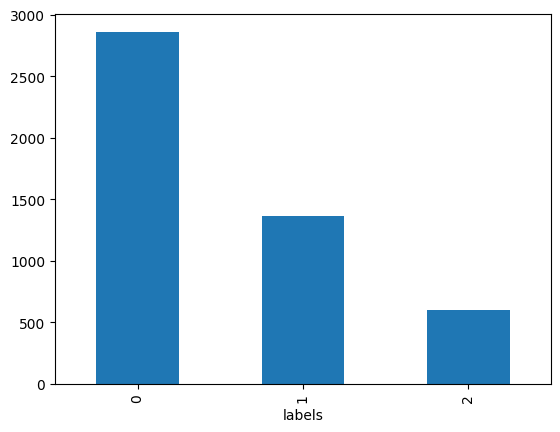

In [27]:
# 레이블 분포 그래프
df_data['labels'].value_counts().plot(kind='bar')

In [28]:
# 레이블 분포
print('레이블의 분포')
print(df_data.groupby('labels').size().reset_index(name='count'))

# 레이블 분포 비율율
print(f'중립의 비율 = {round(df_data["labels"].value_counts()[0]/len(df_data) * 100,3)}%')
print(f'긍정의 비율 = {round(df_data["labels"].value_counts()[1]/len(df_data) * 100,3)}%')
print(f'부정의 비율 = {round(df_data["labels"].value_counts()[2]/len(df_data) * 100,3)}%')



레이블의 분포
   labels  count
0       0   2861
1       1   1362
2       2    604
중립의 비율 = 59.271%
긍정의 비율 = 28.216%
부정의 비율 = 12.513%


In [29]:
# 훈련데이터 레이블링 데이터 분리
x_data = df_data['kor_sentence'].values
y_data = df_data['labels'].values

print('본문의 개수: {}'.format(len(x_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4827
레이블의 개수: 4827


In [30]:
# 훈련, 테스트 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [31]:
print('훈련 샘플의 개수 :', len(x_train))
print('테스트 샘플의 개수 :', len(x_test))

print(f'\n훈련 데이터 : {len(x_train)}, [중립, 긍정, 부정] : {np.bincount(y_train)}')
y_train = pd.Series(y_train)
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')

print(f'\n테스트 데이터 : {len(y_test)}, [중립, 긍정, 부정] : {np.bincount(y_test)}')
y_test = pd.Series(y_test)
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')


훈련 샘플의 개수 : 3861
테스트 샘플의 개수 : 966

훈련 데이터 : 3861, [중립, 긍정, 부정] : [2289 1089  483]
--------훈련 데이터의 비율-----------
중립 = 59.285%
긍정 = 28.205%
부정 = 12.51%

테스트 데이터 : 966, [중립, 긍정, 부정] : [572 273 121]
--------테스트 데이터의 비율-----------
중립 = 59.213%
긍정 = 28.261%
부정 = 12.526%


In [32]:
okt = Okt()
print(okt.morphs(x_train[4]))

# TfidfVectorizer는 기본적으로 공백 기준으로 구분함.
# okt.morphs 메서드를 전달해서 형태소 분석으로 토큰화 수행
tfidf = TfidfVectorizer(ngram_range=(1, 2),     # 유니그램과 바이그램 사용
                        min_df=3,               # 3회 미만으로 등장하는 토큰 무시
                        max_df=0.9,             # 상위 10% 토큰 무시
                        tokenizer=okt.morphs,   # 토큰화를 위한 사용자 정의 함수 전달
                        token_pattern=None)

tfidf.fit(x_train)
x_train_okt = tfidf.transform(x_train)
x_test_okt = tfidf.transform(x_test)

['거래', '금액', '은', 'SEK', '25', 'm', '에서', 'SEK', '50', 'm', '사이', '로', '추정', '됩니다', '.']


In [34]:
sgd = SGDClassifier(loss='log_loss', random_state=1)
param_dist = {'alpha' : loguniform(0.0001, 100.0)}
rsv_okt = RandomizedSearchCV(estimator=sgd,
                            param_distributions=param_dist,
                            n_iter=50,
                            random_state=1,
                            verbose=1)
rsv_okt.fit(x_train_okt, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=SGDClassifier(loss='log_loss', random_state=1),
                   n_iter=50,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000154344DF6B0>},
                   random_state=1, verbose=1)

In [35]:
print(rsv_okt.best_score_)
print(rsv_okt.best_params_)

rsv_okt.score(x_test_okt, y_test)

0.7612059200075073
{'alpha': np.float64(0.00010015813955858975)}


0.7795031055900621

In [36]:
lto = LTokenizer()
print(lto.tokenize(x_data[4]))

['2009-2012년', '회사의', '업데이트된', '전략에', '따르면,', 'Basware는', '20%', '-', '40%', '범위의', '장기적인', '순매출', '성장을', '목표로', '하고', '있으며,', '영업이익률은', '순매출액의', '10%', '-', '20%를', '목표로', '하고', '있습니다.']


In [37]:
word_ext = WordExtractor()
word_ext.train(x_train)
scores = word_ext.word_scores()


training was done. used memory 0.556 Gbry 0.542 Gb
all cohesion probabilities was computed. # words = 6600
all branching entropies was computed # words = 11525
all accessor variety was computed # words = 11525


In [38]:
print(scores.keys())

dict_keys(['리아,', '1999', '않는다.', '커뮤니케이션', '번째', 'OY', '006', '살로몬', '습니다"라고', '1일부', '경쟁', '봄', '13.6', '파노스타자는', '키의', '음료', '수료', '언론', '추산하고', 'Kal', '산업은', 're는', '스카는', 'Glasto', '2004년', '게임', '.2', '.9', '업체가', '사용하고', 'CapM', '장인', 'Ka', '박', '행을', '리고', '러시아,', '정상', '회사이다.', '실을', '디자인', '티쿠릴라', '급증했', '되면서', '업이다.', '노키아', '.5mln', '유형의', '될', '도', '관', '서비스에', '접', '낸셜', '것이다', '세인트루', '체결했습니', '이것', '모의', '12개', '중에', '상반기의', '9%', '위치', '바이오히', 'EUR2', '계획이다.', 'kka', 'Ti', '인도의', '60만', '소는', '매각', '008년', '1억5', '실행', '있다고', '치인', '키아의', '석유', '절', '3월', '말한다', '가,', '하락했', '임업', '파이낸', '물량', '부문에서', '이즈', '륨', 'San', '시스오', 'Oyj)', '(A', '의사', '항목', '순매', '제공하기', '테크', '린덱스', '업손실은', '르크', '아스포콤프', '전했', '코네크', '내용', '준을', '제조업체인', '연구개발', '코네크란', '회사를', '소규모', '루마니아', '러나', '국가들에', '캘리', '배관', '매출액이', 'ri', '2006년에', '텔', '상의', '모델링', "다'라고", '단', '획을', '설', '레밍크+아', '점과', '설립하', '부분은', '크로스컨', '.3%', '판매량', '로는', '니아', '국,', 'M은', '오디오', '마감', '줄었', '행사', '2억', '요구

In [39]:
for word, score in scores.items():
    print(f"단어: {word}, 점수: {score}")


단어: 리아,, 점수: Scores(cohesion_forward=0, cohesion_backward=np.float64(0.06390939808867849), left_branching_entropy=0, right_branching_entropy=0, left_accessor_variety=0, right_accessor_variety=0, leftside_frequency=0, rightside_frequency=6)
단어: 1999, 점수: Scores(cohesion_forward=np.float64(0.15336829564151186), cohesion_backward=0, left_branching_entropy=0, right_branching_entropy=0, left_accessor_variety=0, right_accessor_variety=0, leftside_frequency=5, rightside_frequency=0)
단어: 않는다., 점수: Scores(cohesion_forward=np.float64(0.3696394113101294), cohesion_backward=0, left_branching_entropy=-0.0, right_branching_entropy=-0.0, left_accessor_variety=1, right_accessor_variety=1, leftside_frequency=5, rightside_frequency=0)
단어: 커뮤니케이션, 점수: Scores(cohesion_forward=np.float64(0.7191166284853481), cohesion_backward=0, left_branching_entropy=0, right_branching_entropy=0, left_accessor_variety=0, right_accessor_variety=0, leftside_frequency=5, rightside_frequency=0)
단어: 번째, 점수: Scores(cohesion_for

In [69]:
score_dict = {key: scores[key].cohesion_forward *
                math.exp(scores[key].right_branching_entropy)
                for key in scores}

In [70]:
lto = LTokenizer(scores=score_dict)
print(lto.tokenize(x_train[4]))

['거래', '금액은', 'SE', 'K25m에서', 'SE', 'K50m', '사이', '로', '추정', '됩니다.']


In [71]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        min_df=3,
                        max_df=0.9,
                        tokenizer=lto.tokenize,
                        token_pattern=None)
tfidf.fit(x_train)
x_train_soy = tfidf.transform(x_train)
x_test_soy = tfidf.transform(x_test)

In [ ]:
rsv_soy = RandomizedSearchCV(estimator=sgd,
                             param_distributions=param_dist,
                             n_iter=50,
                             random_state=1,
                             verbose=1)
rsv_soy.fit(x_train_soy, y_train)

y_pred = rsv_soy.best_estimator_.predict(x_test)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=SGDClassifier(loss='log_loss', random_state=1),
                   n_iter=50,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E1918BB3E0>},
                   random_state=1, verbose=1)

In [74]:
print(rsv_soy.best_score_)
print(rsv_soy.best_params_)

0.7568014397844346
{'alpha': np.float64(0.00010015813955858975)}


In [75]:
rsv_soy.score(x_test_soy, y_test)

0.7639751552795031

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
import re

cur_dir = os.path.dirname(__file__)
stop = pickle.load(open(
    os.path.join(cur_dir,
                'pkl_objects',
                'stipwords.pkl'), 'rb'))

def tokenizer(text):
    text = re.sub('<[^>]')
    emotions = re.findall()
    text = re.sub()
    tokenized = []
    return tokenized

dest = os.path.join("movieClassfier", "pkl_objects")
if not os.path.exists(dest):
    os.mkdirs(dest)

pickle.dump()

In [40]:
import pickle
import os

# 디렉토리 생성
dest = os.path.join('classifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

# 불용어 없기 때문에 제외
# pickle.dump(stop,
#             open(os.path.join(dest, 'stopwords.pkl'), 'wb'),
#             protocol=4)

# 모델 직렬화
pickle.dump(rsv_okt,
            open(os.path.join(dest, 'classifier.pkl'), 'wb'),
            protocol=4)